# Violence Detection System

by [Dolev saadia (Github)](https://github.com/dolevsaadia)and[George koozi (Github)](https://github.com/georgekouzi)

## Introduction

It is a system for detecting violence. 

The system uses extracting a set of frames belonging to the video, sending them to a pretrained network called ```VGG16```, obtaining the output of one of its final layers and from these outputs train another network called ```LSTM```.

LSTM have memory and are able to analyze the temporal information of the video and can distinguish between a video that had violence and a video that did not.


If the dataset ```already exists``` than```skip the first step``` which is to download the data.

if you want to put your own dataset put it into the project folder, in folder named```data/Violence``` the Violence data and in folder named```data/NonViolence``` the non Violence data. 



  ## Prerequisites
* [Python3](https://www.python.org/)
* [opencv-python](https://pypi.python.org/pypi/opencv-python)
* [numpy](http://www.numpy.org)
* [matplotlib](https://matplotlib.org/users/installing.html)
* [keras](https://pypi.org/project/Keras/)
* [h5py](http://docs.h5py.org/en/stable/build.html)


# How to install
Make sure python3 and pip is installed.
  
 then install:

##### install opencv-python
pip install cv2
##### install PyWavelets
pip install numpy
##### install matplotlib
python -m pip install -U matplotlib 
##### install keras
pip install Keras
##### install h5py
pip install h5py

# Imports

In [23]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import load_model
import sys
import h5py
import sys
import os
import urllib.request
import tarfile
import zipfile

In [24]:
tf.__version__

'2.4.1'

# Functions for dataset downloads

#### We will use the function ``download_data`` to download the datasets

In [25]:
def download_data(in_dir, url):
    
    if not os.path.exists(in_dir):
        os.makedirs(in_dir)
    
    maybe_download_and_extract(url,in_dir,'data.zip')

#### We will use the function ```print_progress``` to print the amount of videos processed.

In [26]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

#### We will use the function ```maybe_download_and_extract``` to Download and extract the data if it doesn't already exist.

In [27]:
def maybe_download_and_extract(url, download_dir,filename):
   
    file_path = os.path.join(download_dir, filename)
    if not os.path.exists(file_path):
    
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)
        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")

#### We will use the function ```_print_download_progress``` to print the amount of download processed.

In [28]:
def _print_download_progress(count, block_size, total_size):


    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()


#### the url for the dataset``` was takken from ```https://www.kaggle.com/mohamedmustafa/real-life-violence-situations-dataset
#### we uploaded the dataset to dropbox.

#### define the url.

In [29]:
Dataset_url = "https://uc0a6ccd14c79e7dcd238b7a5b6e.dl.dropboxusercontent.com/cd/0/get/BGviIYEA84RlPMt7Vf5m9pRLWd5ow6lhmXnqmVwnRrf5iSiQjzC-_wLOorgM-O2OJX0ONhgV35LP2blfJyWcJb_dVTagxkweaTpfVmTJ8dRKnVRYyKMK4lnjC07y-ATgIFY/file"

# Load Data

#### First of all, we define the directory to place the video dataset

In [30]:
in_dir = "data"

In [31]:
download_data(in_dir,Dataset_url)

Data has apparently already been downloaded and unpacked.


In [32]:
data_dir = "data\Real Life Violence Dataset"

#### Copy some of the data-dimensions for convenience.

In [33]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

#### Function used to get 20 frames from a video file and convert the frame to a suitable format for the neural net.

In [34]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(file_name)
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

#### Function used to label the dataset to Violence and NonViolence

In [35]:
def label_video_names(data_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    dir_name_labales = {
        "data\\Real Life Violence Dataset\\Violence":[1,0],
        "data\\Real Life Violence Dataset\\NonViolence":[0,1]
    }
    
    for current_dir, dir_names,file_names in os.walk(data_dir):
        
        for file_name in file_names:
            
                labels.append(dir_name_labales[current_dir])
                names.append(os.path.join(current_dir, file_name))
           
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

## Plot a video frame to see if data is correct

#### get the names and labels of the whole videos

In [36]:
names, labels = label_video_names(data_dir)

#### print the path and the name for the chosen video.

In [37]:
names[12]

'data\\Real Life Violence Dataset\\NonViolence\\NV_3.mp4'

#### load 20 frames of one video for example.

In [38]:
frames = get_frames(in_dir, names[12])

#### to plot the frames we convert the frames back into uint8 pixel format.

In [39]:
visible_frame = (frames*255).astype('uint8')

#### plot frames

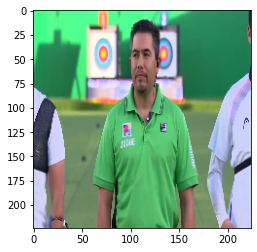

In [40]:
plt.imshow(visible_frame[3])

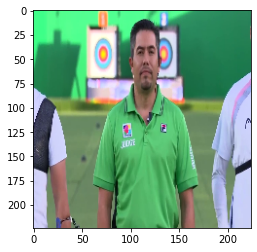

In [41]:
plt.imshow(visible_frame[15])

## Pre-Trained Model: VGG16

The following creates an instance of the pre-trained VGG16 model using the Keras API. This automatically downloads the required files, if you don't have them already.

The VGG16 model contains a CNN part and a fully-connected (or dense) part, which is used for classification. If include_top=True then the whole VGG16 model is downloaded, which is about 528 MB. If include_top=False then only the convolutional part of the VGG16 model is downloaded, which is 57 MB.

In [42]:
image_model = VGG16(include_top=True, weights='imagenet')

#### Let's see the model summary

In [43]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We can observe the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3. Note that we have defined the frame size as 224x224x3. The video frame will be the input of the VGG16 net.

In [75]:
input_shape = image_model.layers[0].output_shape[1:3]
input_shape

[]

### VGG16 model flowchart

The following chart shows how the data flows when using the VGG16 model for Transfer Learning. First we input and process 20 video frames in batch with the VGG16 model. Just prior to the final classification layer of the VGG16 model, we save the so-called Transfer Values to a cache-file.

The reason for using a cache-file is that it takes a long time to process an image with the VGG16 model. If each image is processed more than once then we can save a lot of time by caching the transfer-values.

When all the videos have been processed through the VGG16 model and the resulting transfer-values are saved in to a cache file, then we can use those transfer-values as the input to LSTM neural network. We will then train the second neural network by using the classes from the violence dataset (Violence, No-Violence), so that the network can learn how to classify images based on the transfer-values from the VGG16 model.

In [76]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


#### Function to process 20 video frames through VGG16 and get transfer values

In [77]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

#### Generator that process one video through VGG16 each function call

In [78]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

#### Functions to save transfer values from VGG16 used for training


In [79]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('training.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1
            

#### Functions to save transfer values from VGG16 used for testing


In [109]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('validation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1
            

### Split the dataset into training set and test set
We are going to split the dataset into training set and testing. The training set is used to train the model and the test is used to check the model accuracy.

In [81]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]


## make the training set

 Then we will process all the video frames for training through VGG16 and save the transfer-values.

In [143]:
make_files(training_set)

## make the testing set

 Then we will process 20% the video frames for testing through VGG16 and save the transfer-values.

In [144]:
make_files_test(test_set)

- Progress: 99.8%

### Load the cached transfer values into memory
We saved all the video frames transfer-values into a disk, but we have to load those transfer-values into memory in order to train the LSTM net. if you didn't save the transfer-values into disk you would have to process the whole videos each training. It's a time consuming way to processe the videos through VGG16 net. 


### functions to load the saved transfer-values into RAM memory.

In [111]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('training.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [112]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('validation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

#### load the saved transfer-values

In [84]:
data, target = process_alldata_training()

In [85]:
data_test, target_test = process_alldata_test()

## Recurrent Neural Network

The basic building block in a Recurrent Neural Network (RNN) is a Recurrent Unit (RU). There are many different variants of recurrent units such as the rather clunky LSTM (Long-Short-Term-Memory) and the somewhat simpler GRU (Gated Recurrent Unit) which we will use in this tutorial. Experiments in the literature suggest that the LSTM and GRU have roughly similar performance. Even simpler variants also exist and the literature suggests that they may perform even better than both LSTM and GRU, but they are not implemented in Keras which we will use in this tutorial.

A recurrent neuron has an internal state that is being updated every time the unit receives a new input. This internal state serves as a kind of memory. However, it is not a traditional kind of computer memory which stores bits that are either on or off. Instead the recurrent unit stores floating-point values in its memory-state, which are read and written using matrix-operations so the operations are all differentiable. This means the memory-state can store arbitrary floating-point values (although typically limited between -1.0 and 1.0) and the network can be trained like a normal neural network using Gradient Descent.



### Define LSTM architecture

When defining the LSTM architecture we have to take into account the dimensions of the transfer values. From each frame the VGG16 network obtains as output a vector of 4096 transfer values. From each video we are processing 20 frames so we will have 20 x 4096 values per video. The classification must be done taking into account the 20 frames of the video. If any of them detects violence, the video will be classified as violent.


The first input dimension of LSTM neurons is the temporal dimension, in our case it is 20. The second is the size of the features vector (transfer values).


In [86]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

## Model training


In [87]:
def train_the_model(ep):
    epoch = ep
    batchS = 500

    history = model.fit(np.array(data[0:750]), np.array(target[0:750]), epochs=epoch,
                    validation_data=(np.array(data[750:]), np.array(target[750:])), 
                    batch_size=batchS, verbose=2)
    

In [88]:
def retrain_the_model(ep,modlename):
    epoch = ep
    batchS = 500

    history = modlename.fit(np.array(data[0:750]), np.array(target[0:750]), epochs=epoch,
                    validation_data=(np.array(data[750:]), np.array(target[750:])), 
                    batch_size=batchS, verbose=2)
    

In [89]:
train_the_model(20)

Epoch 1/20
2/2 - 5s - loss: 0.3207 - accuracy: 0.4933 - val_loss: 0.3039 - val_accuracy: 0.4976
Epoch 2/20
2/2 - 5s - loss: 0.2929 - accuracy: 0.4800 - val_loss: 0.2628 - val_accuracy: 0.5024
Epoch 3/20
2/2 - 4s - loss: 0.2598 - accuracy: 0.5040 - val_loss: 0.2490 - val_accuracy: 0.5035
Epoch 4/20
2/2 - 4s - loss: 0.2520 - accuracy: 0.4840 - val_loss: 0.2516 - val_accuracy: 0.4976
Epoch 5/20
2/2 - 4s - loss: 0.2506 - accuracy: 0.4960 - val_loss: 0.2495 - val_accuracy: 0.5024
Epoch 6/20
2/2 - 4s - loss: 0.2508 - accuracy: 0.5040 - val_loss: 0.2512 - val_accuracy: 0.5024
Epoch 7/20
2/2 - 5s - loss: 0.2506 - accuracy: 0.5040 - val_loss: 0.2482 - val_accuracy: 0.6918
Epoch 8/20
2/2 - 5s - loss: 0.2482 - accuracy: 0.6200 - val_loss: 0.2485 - val_accuracy: 0.4976
Epoch 9/20
2/2 - 5s - loss: 0.2490 - accuracy: 0.4960 - val_loss: 0.2458 - val_accuracy: 0.6494
Epoch 10/20
2/2 - 4s - loss: 0.2459 - accuracy: 0.6107 - val_loss: 0.2464 - val_accuracy: 0.5024
Epoch 11/20
2/2 - 5s - loss: 0.2462 - a

## Test the model

We test the model with 20% of the total videos, that were splited. this videos weren't used to train the model.

In [90]:
result = model.evaluate(np.array(data_test), np.array(target_test))

13/13 [==============================] - 4s 314ms/step - loss: 0.1863 - accuracy: 0.7250


In [91]:
model.save("result.h5")

## Print the model accuracy and loss

In [92]:
for name, value in zip(model.metrics_names, result):
    print(name,round(value,2))

loss 0.19
accuracy 0.73


In [93]:
#### funcion for Print the model accuracy as grpah 

In [94]:
def plot_results(history):  
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.legend()
    plt.show()
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.legend()
    plt.show()

## Print the model accuracy and loss

In [1]:
plot_results(history)    

NameError: name 'plot_results' is not defined

## Load the model

In [8]:
model = load_model('result.h5')
result = model.evaluate(np.array(data_test), np.array(target_test))

NameError: name 'load_model' is not defined

## retrain the model

In [ ]:
train_the_model(20)

In [ ]:
model.save("result.h5")

## Print the model accuracy and loss after retrain

In [7]:
plot_results(history) 

NameError: name 'plot_results' is not defined

In [3]:
def check_new_videos(new_dir): 
    n = label_video_names1(new_dir)
    test_set1 = int(len(n)) 
    make_new_video_test(len(n),new_dir)
    test_set1, target_test1 = process_alldata_test1()
     
    transfer_values =  image_model_transfer.predict(image_batch)
           
    for name in zip(model.metrics_names, result):
        result = model.evaluate(np.array(test_set1), np.array(target_test1))
        if res > 0.5:
            string = str(name) + " Pistol Detected: " + str(value)
        elif res < 0.5:
            string = str(name) + " No Weapon Detected: " + str(value)
            

In [5]:
new_data_dir = "data\new video"

In [6]:
check_new_videos(new_data_dir)

NameError: name 'label_video_names1' is not defined